--- INFO O STRUKTURZE ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16674 entries, 0 to 16673
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Nazwa               16674 non-null  object
 1   Transakcje rynkowe  16674 non-null  object
 2   Rok                 16674 non-null  int64 
 3   Wartosc             16674 non-null  object
dtypes: int64(1), object(3)
memory usage: 521.2+ KB
None

Liczba wartości z '-' w kolumnie 'Wartosc': 9

--- BRAKI W DANYCH ---
Nazwa                 0
Transakcje rynkowe    0
Rok                   0
Wartosc               0
cena_numeric          0
dtype: int64
Liczba zerowych cen w podziale na typ transakcji rynkowej:


,Transakcje rynkowe,Liczba_zerowych_cen
0,ogółem,109
1,rynek pierwotny,1457
2,rynek wtórny,112


------------------------------------------------------------
Liczba wierszy w df_clean przed usunięciem zer: 16674
Liczba wierszy w df_clean po usunięciu zer: 14996
------------------------------------------------------------

--- WARTOŚCI W KOLUMNIE GRUPUJĄCEJ ---
['ogółem' 'rynek pierwotny' 'rynek wtórny']
------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Transakcje rynkowe,,,,,,,,
ogółem,5558.0,3384.07,1526.86,0.0,2448.0,3035.5,4071.75,16144.0
rynek pierwotny,5558.0,3260.96,2370.42,0.0,0.0,3584.5,4600.50,27720.0
rynek wtórny,5558.0,3195.55,1480.62,0.0,2305.0,2828.0,3807.75,15462.0


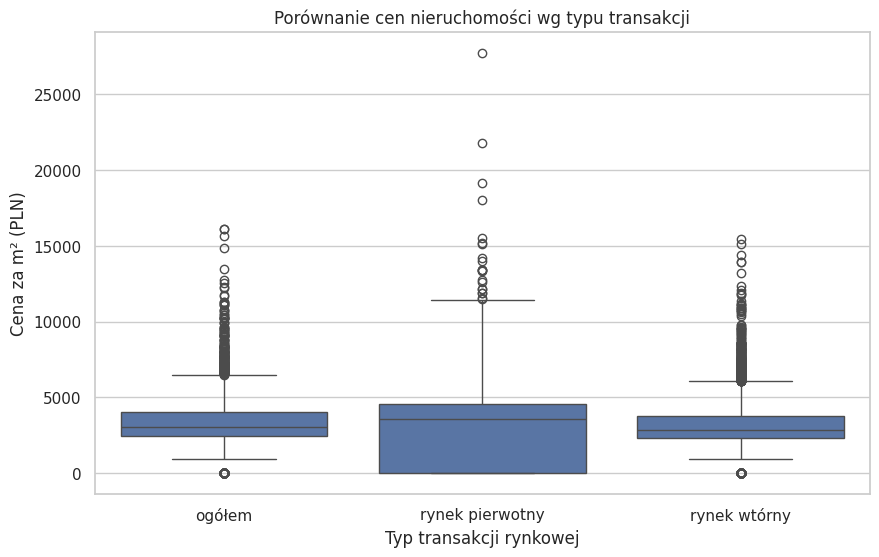

------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Transakcje rynkowe,,,,,,,,
ogółem,5400.0,3384.84,1279.03,957.0,2477.0,3054.0,4061.75,9026.0
rynek pierwotny,4029.0,4293.84,1213.25,2018.0,3417.0,4044.0,4939.00,9023.0
rynek wtórny,5407.0,3205.13,1255.74,957.0,2332.0,2849.0,3807.00,9021.0


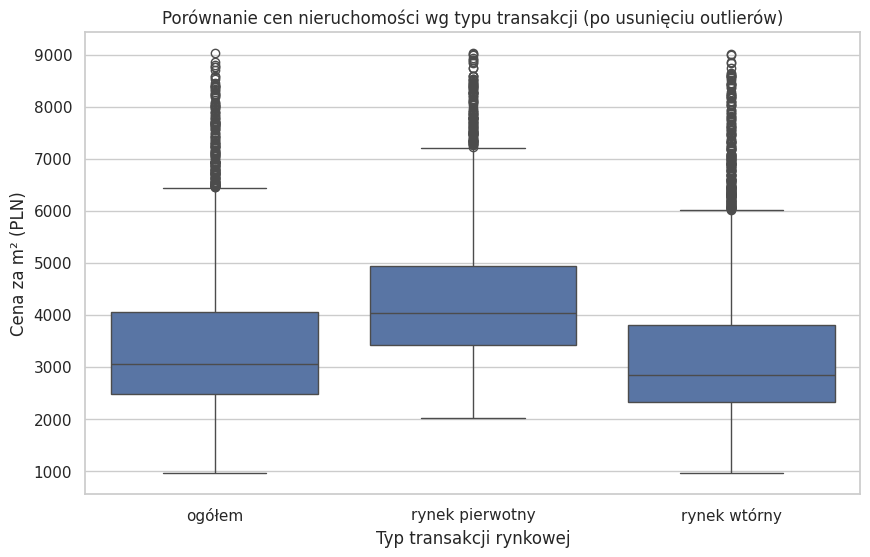

------------------------------------------------------------


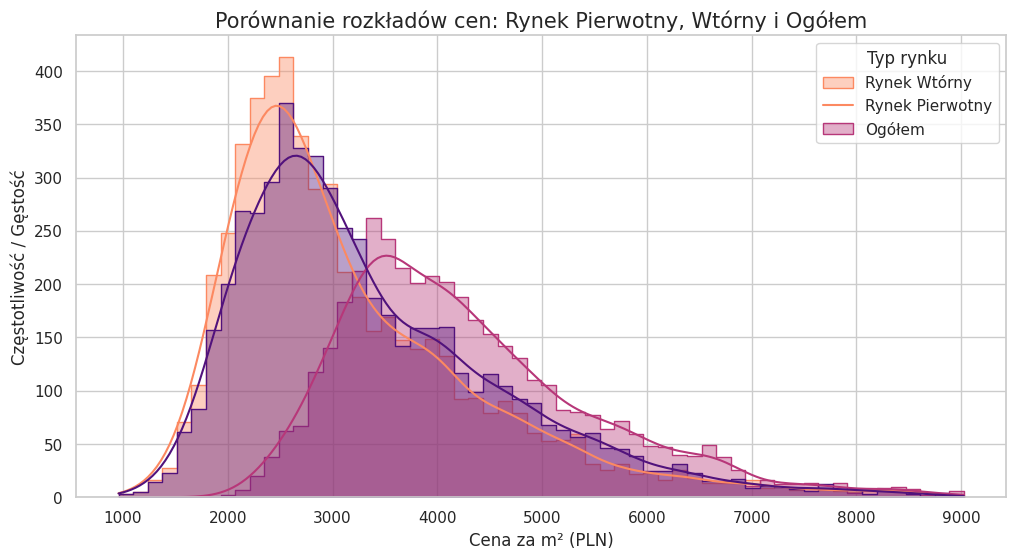

------------------------------------------------------------
Średnie ceny nieruchomości dla województw


,Nazwa,cena_numeric
0,DOLNOŚLĄSKIE,5004.785714
1,KUJAWSKO-POMORSKIE,4130.357143
2,LUBELSKIE,4766.428571
3,LUBUSKIE,3400.809524
4,MAZOWIECKIE,7395.571429
5,MAŁOPOLSKIE,6670.428571
6,OPOLSKIE,3641.047619
7,PODKARPACKIE,4146.452381
8,PODLASKIE,4582.452381
9,POMORSKIE,5909.500000


Summary Table:
Market               ogółem  rynek pierwotny  rynek wtórny  Różnica (P-W)
Region                                                                   
MAŁOPOLSKIE           10446            10383         10528           -145
MAZOWIECKIE           10317             8898         11852          -2954
ZACHODNIOPOMORSKIE     6945             8743          5900           2843
POMORSKIE              8571             8532          8623            -91
DOLNOŚLĄSKIE           7607             8435          6903           1532
LUBELSKIE              7460             7805          7081            724
ŁÓDZKIE                6797             7483          6321           1162
ŚWIĘTOKRZYSKIE         6513             7108          6066           1042
PODLASKIE              7101             7031          7196           -165
WIELKOPOLSKIE          6917             7030          6766            264
ŚLĄSKIE                5826             6916          5213           1703
WARMIŃSKO-MAZURSKIE    

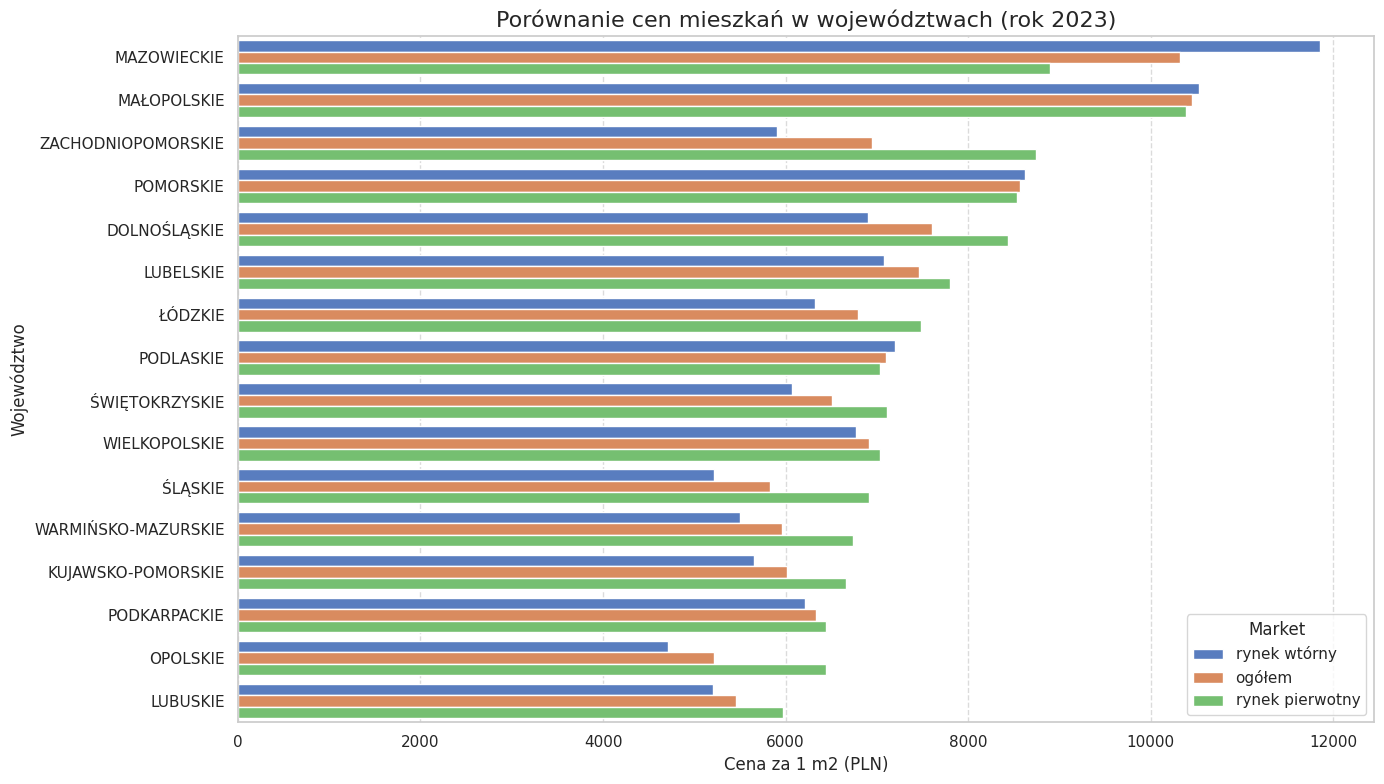

In [67]:
import pandas as pd
import numpy as np
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Ładowanie
# Pobieranie pliku z GitHub
github_excel_url = 'https://raw.githubusercontent.com/MatiMajewski/Beginners/refs/heads/main/RYNEK_NIER.xlsx'
response = requests.get(github_excel_url)
df_org = pd.read_excel(io.BytesIO(response.content), header=0)

df = df_org.copy()

# 2. Czyszczenie danych
# Diagnostyka struktury
print("--- INFO O STRUKTURZE ---")
print(df.info())

# Liczenie '-'
num_hyphens = df['Wartosc'].astype(str).str.contains('-').sum()
print(f"\nLiczba wartości z '-' w kolumnie 'Wartosc': {num_hyphens}")

# Konwersja wartości na typ numeryczny.
df['Wartosc'] = df['Wartosc'].astype(str).str.replace('-', '0', regex=False) # Zmiana: zamiana '-' na '0'
df['cena_numeric'] = pd.to_numeric(df['Wartosc'], errors='coerce')

# Usunięcie wierszy z brakującymi wartościami w 'cena_numeric' i przypisanie do df_clean
df_clean = df.dropna(subset=['cena_numeric'])

# Sprawdzenie braków i unikalnych wartości
print("\n--- BRAKI W DANYCH ---")
print(df.isnull().sum())

# Sprawdzanie wartości 0 w kolumnie 'Wartosc'
zero_price_rows = df_clean[df_clean['cena_numeric'] == 0]
zero_counts_by_market = zero_price_rows.groupby('Transakcje rynkowe').size().reset_index(name='Liczba_zerowych_cen')

print("Liczba zerowych cen w podziale na typ transakcji rynkowej:")
display(zero_counts_by_market)

# Usuwamy wiersze z wartościami 0
initial_rows_in_df_clean = len(df_clean)
df_clean = df_clean[df_clean['cena_numeric'] != 0].copy()
print("------------------------------------------------------------")
print(f"Liczba wierszy w df_clean przed usunięciem zer: {initial_rows_in_df_clean}")
print(f"Liczba wierszy w df_clean po usunięciu zer: {len(df_clean)}")

print("------------------------------------------------------------")
print("\n--- WARTOŚCI W KOLUMNIE GRUPUJĄCEJ ---")
# Sprawdzamy, czy 'rynek pierwotny' nie jest zapisany na 3 różne sposoby (np. z literówkami)
print(df['Transakcje rynkowe'].unique())



# 3. Statystyki opisowe
# Statystyki opisowe
stats_desc = df.groupby('Transakcje rynkowe')['cena_numeric'].describe().round(2)
print("------------------------------------------------------------")
display(stats_desc)

# Wizualizacja rozkładu z ekstremami
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Transakcje rynkowe', y='cena_numeric')
plt.title("Porównanie cen nieruchomości wg typu transakcji")
plt.xlabel("Typ transakcji rynkowej")
plt.ylabel("Cena za m² (PLN)")
plt.show()

# Obliczanie Q1, Q3 i IQR do usuwania outlierów z df_clean
Q1 = df_clean['cena_numeric'].quantile(0.15)
Q3 = df_clean['cena_numeric'].quantile(0.85)
IQR = Q3 - Q1

# Definiowanie granic dla outlierów
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrowanie outlierów i przypisanie do df_outliers, aby uwzględnić wszystkie typy rynkowe, w tym 'ogółem'
df_outliers = df_clean[(df_clean['cena_numeric'] >= lower_bound) & (df_clean['cena_numeric'] <= upper_bound)].copy()

# Statystyki opisowe
stats_desc = df_outliers.groupby('Transakcje rynkowe')['cena_numeric'].describe().round(2)
print("------------------------------------------------------------")
display(stats_desc)

# Wizualizacja rozkładu
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_outliers, x='Transakcje rynkowe', y='cena_numeric')
plt.title("Porównanie cen nieruchomości wg typu transakcji (po usunięciu outlierów)")
plt.xlabel("Typ transakcji rynkowej")
plt.ylabel("Cena za m² (PLN)")
plt.show()

print("------------------------------------------------------------")
# Porównanie rozkładu cen bez ekstremów
# Ustawienie estetyki wykresów
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Generowanie histogramu z krzywą gęstości (KDE)
# Teraz uwzględniamy wszystkie typy transakcji rynkowych
plot_data = df_outliers

sns.histplot(
    data=plot_data,
    x='cena_numeric',
    hue='Transakcje rynkowe',
    kde=True,
    element="step",
    palette='magma',
    alpha=0.4
)

plt.title('Porównanie rozkładów cen: Rynek Pierwotny, Wtórny i Ogółem', fontsize=15)
plt.xlabel('Cena za m² (PLN)', fontsize=12)
plt.ylabel('Częstotliwość / Gęstość', fontsize=12)
# Zaktualizowana legenda dla wszystkich trzech kategorii
plt.legend(title='Typ rynku', labels=['Rynek Wtórny', 'Rynek Pierwotny', 'Ogółem'])

plt.show()


print("------------------------------------------------------------")
voivodeships = [
    'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE', 'LUBUSKIE',
    'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE', 'PODKARPACKIE',
    'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE', 'ŚWIĘTOKRZYSKIE',
    'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE', 'ZACHODNIOPOMORSKIE'
]

df_voivodeships = df_clean[df_clean['Nazwa'].isin(voivodeships)]
average_prices_by_voivodeship = df_voivodeships.groupby('Nazwa')['cena_numeric'].mean().reset_index()

styled_table = average_prices_by_voivodeship.style\
    .background_gradient(cmap='Greens', subset=['cena_numeric']) \
    .set_properties(**{'border-color': '#0a0a0a', 'border-style': 'solid', 'border-width': '1px'}) \
    .set_table_styles([{'selector': 'td, th', 'props': [('border', '1px solid #0a0a0a')]}]) # Dodaj obramowanie do komórek

print("Średnie ceny nieruchomości dla województw")
display(styled_table)


# 1. Ładowanie i czyszczenie danych
# Użyj pd.read_excel dla plików .xlsx i ustaw header=0
df_processed = df.copy() # Tworzenie kopii, aby uniknąć modyfikowania oryginalnego obiektu df, jeśli jest używany gdzie indziej

# Zmień nazwy kolumn na bardziej wygodne dla reszty skryptu, jeśli to konieczne,

df_processed.rename(columns={'Nazwa': 'Region', 'Transakcje rynkowe': 'Market', 'Rok': 'Year', 'Wartosc': 'Price'}, inplace=True)

df_processed['Price'] = pd.to_numeric(df_processed['Price'], errors='coerce')
df_processed = df_processed[df_processed['Price'] > 0]

# Lista województw
voivodeships = [
    'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE', 'LUBUSKIE',
    'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE', 'PODKARPACKIE',
    'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE', 'ŚWIĘTOKRZYSKIE',
    'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE', 'ZACHODNIOPOMORSKIE'
]

# 2. EDA: Filtrowanie dla roku 2023 i województw
latest_year = 2023
df_2023 = df_processed[(df_processed['Region'].isin(voivodeships)) & (df_processed['Year'] == latest_year)].copy()

# Tabela podsumowująca dla użytkownika
summary_pivot = df_2023.pivot(index='Region', columns='Market', values='Price')
summary_pivot['Różnica (P-W)'] = summary_pivot['rynek pierwotny'] - summary_pivot['rynek wtórny']
summary_pivot = summary_pivot.sort_values(by='rynek pierwotny', ascending=False)
summary_pivot.to_csv('porownanie_wojewodztw_2023.csv')

# 3. Wizualizacja
plt.figure(figsize=(14, 8))
# Melt dla wykresu
df_plot = df_2023.sort_values(by='Price', ascending=False)
sns.barplot(data=df_plot, y='Region', x='Price', hue='Market', palette='muted')
plt.title(f'Porównanie cen mieszkań w województwach (rok {latest_year})', fontsize=16)
plt.xlabel('Cena za 1 m2 (PLN)', fontsize=12)
plt.ylabel('Województwo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('ceny_wojewodztwa_2023.png')

# 4. Inferencja statystyczna
# Test t-studenta dla par: Czy różnica między rynkiem pierwotnym a wtórnym jest istotna w województwach?
p_market = summary_pivot['rynek pierwotny']
w_market = summary_pivot['rynek wtórny']
t_stat, p_val = stats.ttest_rel(p_market, w_market)

# Przedział ufności dla średniej ceny (wszystkie obserwacje w 2023 r.)
mean_val = df_2023['Price'].mean()
sem_val = stats.sem(df_2023['Price'])
conf_int = stats.t.interval(0.95, len(df_2023['Price'])-1, loc=mean_val, scale=sem_val)

print("Summary Table:")
print(summary_pivot)
print(f"\nStatistical Results for {latest_year}:")
print(f"Mean Price (Voivodeships): {mean_val:.2f} PLN")
print(f"95% CI: {conf_int}")
print(f"Paired t-test (P vs W): t={t_stat:.4f}, p={p_val:.4f}")